# Preamble

Title: *Health Expenditure and Financing for 2015*

Author: *Nicole Weickert*

Email: *nweicker@msudenver.edu*

Last Update: *2021-10-19*

# Introduction

This report examines the total amount spent on healthcare in 2015 for 35 countries, measured in [2010 international dollars](https://en.wikipedia.org/wiki/International_dollar). The data were retrieved from [Our World in Data](https://ourworldindata.org/grapher/health-expenditure-and-financing-per-capita?tab=table) and originally published by [Organisation for Economic Co-operation and Development (OECD)](https://stats.oecd.org/)



# Dataset
The dataset for this report was constructed from information obtained through web scraping techniques at [Health expenditure and Financing (per capita)(OECDstat (2017))](https://ourworldindata.org/grapher/health-expenditure-and-financing-per-capita?tab=table).

The values shown are the total amounts each country spent per capita in 2015 on healthcare. The totals include funding from all sources (both out-of-pocket and government spending) for personal health care, public health services, and health administration but do not include investments.  For more details, open the page above and click the "Sources" tab.

The data displayed on the pages at Our World in Data are not stored within that page, but rather retrieved from a json document stored at a separate url. The script below here first identifies the location of the displayed data and then retrieves it as a json dictionary.

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import json
import pandas as pd
import matplotlib.pyplot as plt


# definitions/parameters
year = 2015
url = "https://ourworldindata.org/grapher/health-expenditure-and-financing-per-capita?tab=table"
title = f"Health Expenditure and Financing for {year}"
x_label = f"Amount spent per capita\n(in 2010 international dollars)"
y_label = "Number of Countries"

In [2]:
# Retrieve page data as json
response = requests.session().get(url)
soup = BeautifulSoup(response.content, "html.parser")

## Data displayed on page is pulled from another location;
## Find the data location and retrieve its contents as json
data_relative_link = soup.find("link", {"as": "fetch"})['href']
data_url = urljoin(url, data_relative_link)
response = requests.session().get(data_url).content
raw_data = json.loads(BeautifulSoup(response, 'html.parser').string)

# Data Pre-processing
Before saving the json to a Pandas DataFrame, some work is needed to remove unneeded information, replace the entity reference codes with the names of the countries, and ensure correct data types.

In [3]:
# Ready information from json for use in DataFrame
entities = raw_data['variables']['1871']['entities']
years = raw_data['variables']['1871']['years']
values = raw_data['variables']['1871']['values']

## Replace entity reference codes with country names
for i in range(len(entities)):
    key = str(entities[i])
    entities[i] = raw_data["entityKey"][key]["name"]

## Create DataFrame with only records for the specified year
df = pd.DataFrame({"Country": entities, "Year": years, "Value": values})
df = df.loc[df["Year"] == year, ["Country", "Value"]]
data = df['Value'].astype('float64')

# Summary Statistics
Next, it calculates and reports the summary statistics for the dataset.


In [4]:
# Calculate and Report Statistics
count, mean, std, min, q1, median, q3, max = data.describe()
iqr = q3 - q1
lower = int(q1 - iqr * 1.5)
upper = int(q3 + iqr * 1.5)

stats = "-- Summary Statistics --\n"
stats += f"Mean: ${int(mean)}\n"
stats += f"Median: ${int(median)}\n"
stats += f"Range: ${int(max-min)}\n"
stats += f"Std Dev: ${int(std)}\n"
print(stats)

outliers = {"Low": [lower, df.loc[df["Value"] < lower]], "High": [upper, df.loc[df["Value"] > upper]]}
for i in outliers:
    results = outliers[i][1]
    print(f"-- {i} Outliers --  (Threshold = ${outliers[i][0]})")
    print("(None)\n") if len(results) == 0 else print(results.to_string(header=False, index=False), '\n')

-- Summary Statistics --
Mean: $3470
Median: $3627
Range: $7758
Std Dev: $1766

-- Low Outliers --  (Threshold = $-1501)
(None)

-- High Outliers --  (Threshold = $8049)
United States  8714.8975 



# Visualizations
Last, it displays a histogram grouping the 35 countries' spending in bins of $1,000 increments and a Box and Whisker Plot to illustrate the summary statistics and outliers.

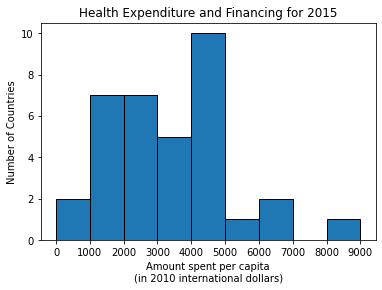

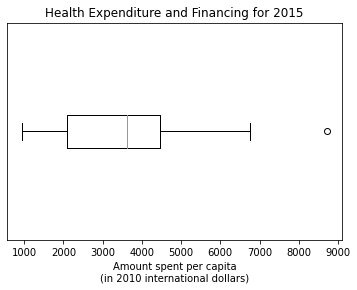

In [5]:
# Configure Histogram
fig, ax = plt.subplots()
bins = list(range(0, 10000, 1000))
counts, bins, patches = ax.hist(data, bins=bins, edgecolor='black')
ax.set_xticks(bins)
plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)

# Configure Box-and-Whisker
fig2, ax2 = plt.subplots()
ax2.boxplot(data, vert=False)
ax2.set_xlabel(x_label)
ax2.set(ylabel=None)
ax2.set(yticklabels=[])
ax2.tick_params(left=False)
ax2.set_title(title)

plt.show()